In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux, align_fluxes_by_reference
from scipy.spatial import cKDTree
import pandas as pd
from multiprocessing.dummy import Pool
from tqdm import tqdm
from astropy.nddata import Cutout2D
import glob
import pickle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

In [3]:
# Set location data
location = '/net/vdesk/data2/deklerk/GAAP_data'

In [4]:
field = '53.0_-28.0'

In [12]:
filters = ['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
sigma = np.zeros(len(filters))
for i, filter in enumerate(filters):
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)

    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]
    hdu = fits.open(image_file[0])[0]
    wcs = WCS(hdu.header)
    print(wcs.wcs_pix2world(0, 0, 0))
    print(wcs.wcs_pix2world(19200, 19200, 0))

[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]
[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]
[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]
[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]
[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]
[array(53.289685), array(-28.26630337)]
[array(52.68564985), array(-27.73298116)]


In [14]:
filters = ['u', 'g', 'r', 'i', 'y', 'z']
for i, filter in enumerate(filters):  
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]
    hdu = fits.open(image_file[0])[1]
    wcs = WCS(hdu.header)
    print(wcs.wcs_pix2world(0, 0, 0))
    print(wcs.wcs_pix2world(3400, 3400, 0))

[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]
[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]
[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]
[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]
[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]
[array(53.10008198), array(-28.03170259)]
[array(52.88644549), array(-27.84267866)]


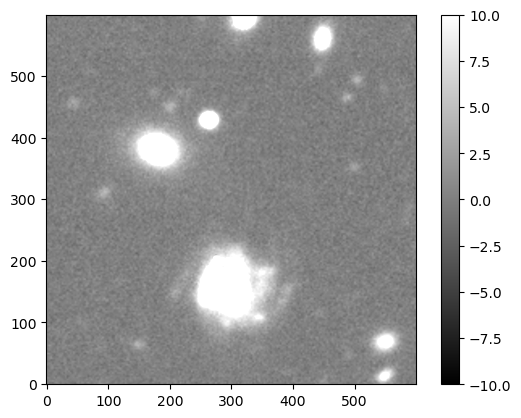

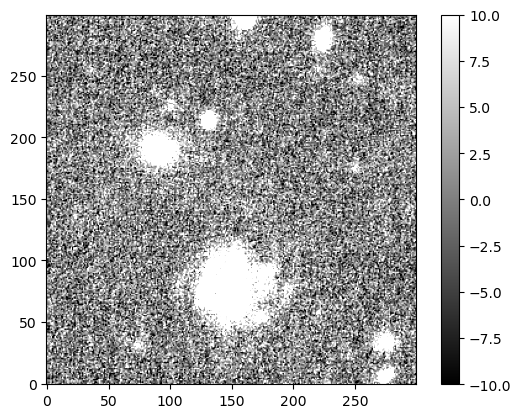

In [23]:
min_x, min_y = 700, 800
max_x, max_y = 1000, 1100
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu1 = fits.open(image_file[0])[1]
wcs1 = WCS(hdu1.header)
files = glob.glob(f'{location}/{field}/DES-G_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu2 = fits.open(image_file[0])[0]
wcs2 = WCS(hdu2.header)
factor = 10**((8.90 - hdu2.header['MAGZERO'])/2.5) * 10**9
# dec_min, ra_min = wcs1.wcs_pix2world(min_x, min_y, 0)
# dec_max, ra_max = wcs1.wcs_pix2world(max_x, max_y, 0)
# print(ra_min, dec_min, ra_max, dec_max)
# x1, y1 = wcs2.wcs_world2pix(dec_min, ra_min, 0)
# x2, y2 = wcs2.wcs_world2pix(dec_max, ra_max, 0)
# y1, y2 = np.sort([y1, y2])
# x1, x2 = np.sort([x1, x2])
# print(x1, x2, y1, y2)
plt.imshow(factor*hdu2.data[int(y1):int(y2), int(x1):int(x2)], origin='lower', cmap='gray', vmin=-10, vmax=10)
# print(np.percentile(hdu2.data*factor, 5), np.percentile(hdu2.data*factor, 95))
# print(np.percentile(hdu1.data, 5), np.percentile(hdu1.data, 95))
plt.colorbar()
plt.show()
plt.imshow(hdu1.data[int(min_y):int(max_y), int(min_x):int(max_x)], origin='lower', cmap='gray', vmin=-10, vmax=10)
plt.colorbar()
plt.show()

In [5]:
telescope = 'euclid'
with open(f'{location}/{field}/{telescope}_dataframe_aperture_10.pkl', 'rb') as f:
    dfs = pickle.load(f)

In [17]:
dfs = {}
filters = ['u', 'g', 'r', 'i', 'y', 'z', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for i, filter in enumerate(filters):
    if len(filter) == 1:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='ascii')
    else:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]
    hdu = fits.open(image_file[0])[1 if len(filter) == 1 else 0]
    wcs = WCS(hdu.header)
    for k in ['BUNIT','EXPTIME','GAIN','MAGZP','ZP','PHOTZP','PHOTFLAM','FLUXCONV','MAGZERO','HIERARCH ESO PRO CHI' ]:
        if k in hdu.header:
            print(f"  {k} = {hdu.header[k]}")
    # print(hdu.header)
    ra, dec = wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0)
    df = pd.DataFrame({
        'ra': ra,
        'dec': dec,
        'flux_auto': catalog['FLUX_AUTO'],
        'fluxerr_auto': catalog['FLUXERR_AUTO']})
    dfs[filter] = df
    

  BUNIT = nJy
  BUNIT = nJy
  BUNIT = nJy
  BUNIT = nJy
  BUNIT = nJy
  BUNIT = nJy
  MAGZERO = 30.0
  MAGZERO = 30.0
  MAGZERO = 30.0
  MAGZERO = 29.8
  MAGZERO = 30.0
  MAGZERO = 29.9


In [61]:
for df in dfs.values():
    print(len(df))
    print(df.head())

1227
          ra        dec  flux_auto  fluxerr_auto
0  52.903342 -28.024356   64041.32      380.2081
1  52.904799 -28.025462   29367.84      491.4522
2  53.084470 -28.026203  513718.90      144.0202
3  52.892912 -28.026907   38532.07      127.2046
4  52.914599 -28.027765  167349.90      139.5447
9084
          ra        dec  flux_auto  fluxerr_auto
0  53.096819 -28.031597   81.31582      8.451106
1  53.034206 -28.031580  147.44530     11.630450
2  52.959428 -28.031416   57.01914      9.477213
3  52.912229 -28.031452  199.21890     10.959810
4  52.992447 -28.031521  132.16470     11.769190
9739
          ra        dec  flux_auto  fluxerr_auto
0  53.052505 -28.031609  104.45650      12.68193
1  52.928107 -28.031446   76.07986      12.89873
2  53.096818 -28.031576   79.48225      10.96181
3  53.094888 -28.031580   62.79541      10.44364
4  52.992433 -28.031544  119.86330      12.97019
8357
          ra        dec  flux_auto  fluxerr_auto
0  53.048004 -28.031633   102.8561      14.86662


In [33]:
def align_fluxes_by_reference(dfs, max_dist=2.0):
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    ra_ref = ref_df['ra'].values
    dec_ref = ref_df['dec'].values
    ref_points = np.column_stack((ra_ref, dec_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        ra = df['ra'].values
        dec = df['dec'].values
        points = np.column_stack((ra, dec))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux_auto'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix

In [64]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=1)
print(bands)
print(flux_matrix.shape)
print(flux_matrix)

['u', 'g', 'r', 'i', 'y', 'z', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
(1227, 12)
[[6.40413200e+04 3.87391300e+05 9.15141400e+05 ... 9.50556641e+04
  4.20600125e+05 3.50458466e+02]
 [2.93678400e+04 7.02684700e+04 1.33029800e+05 ... 1.35400250e+05
  1.31998688e+05 5.41867188e+02]
 [5.13718900e+05 1.20513600e+06 1.58501300e+06 ... 2.03104512e+04
  2.66643359e+04 3.21616531e+05]
 ...
 [3.36803200e+02 8.19977800e+02 1.02745700e+03 ... 4.32579712e+02
  4.84089874e+02 4.78194336e+02]
 [4.88034200e+03 1.39778800e+04 1.84038000e+04 ... 5.82884082e+03
  7.33523242e+03 6.74968701e+03]
 [1.79711300e+02 8.69840700e+01 1.72082300e+02 ... 1.30630676e+02
  6.37866333e+02 1.27502861e+02]]


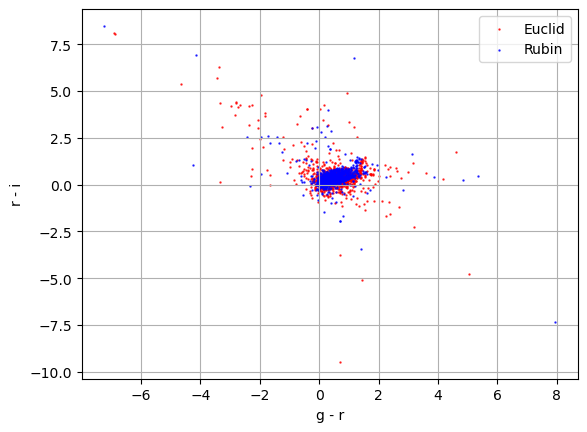

In [74]:
filter_1 = 6
filter_2 = 7
filter_3 = 8

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    plt.scatter(x_color, y_color, c='r', s=.5, alpha=0.8, label='Euclid')
    # plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    # plt.xlim(-1, 3)
    # plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')

filter_1 = 1
filter_2 = 2
filter_3 = 3

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    plt.scatter(x_color, y_color, c='b', s=0.5, alpha=0.8, label='Rubin')
    # plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    plt.legend()
    # plt.xlim(-1, 3)
    # plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

In [88]:
angle_arcsec = 2.0          # separation on sky in arcseconds
position_angle_deg = 90.0    # direction: degrees east of north (astropy convention)

# load
for filter in ['DES-G', 'g']:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]
    hdu = fits.open(image_file[0])[1 if len(filter) == 1 else 0]
    data = hdu.data
    wcs = WCS(hdu.header)

    # image center pixel (use whichever reference pixel you want)
    ny, nx = data.shape[-2], data.shape[-1]   # handles possible multi-dim arrays
    x0 = (nx - 1) / 2.0   # x = column index
    y0 = (ny - 1) / 2.0   # y = row index

    # pixel -> sky (degrees). origin=0 => pixels are 0-indexed
    ra0, dec0 = wcs.wcs_pix2world(x0, y0, 0)

    # make SkyCoord
    center = SkyCoord(ra=ra0 * u.deg, dec=dec0 * u.deg, frame='icrs')

    # apply spherical offset
    sep = angle_arcsec * u.arcsec
    pa = position_angle_deg * u.deg
    newpos = center.directional_offset_by(position_angle=pa, separation=sep)

    # sky -> pixel
    x1, y1 = wcs.wcs_world2pix(newpos.ra.deg, newpos.dec.deg, 0)

    # pixel distance
    pixel_distance = np.hypot(x1 - x0, y1 - y0)

    print(f"Center pixel: ({x0:.3f}, {y0:.3f}) -> RA,Dec = ({ra0:.6f}, {dec0:.6f}) deg")
    print(f"Offset by {angle_arcsec} arcsec at PA={position_angle_deg} deg -> RA,Dec = "
        f"({newpos.ra.deg:.6f}, {newpos.dec.deg:.6f}) deg")
    print(f"Mapped pixel: ({x1:.3f}, {y1:.3f}); pixel distance = {pixel_distance:.3f}")


Center pixel: (9599.500, 9599.500) -> RA,Dec = (52.986936, -27.999986) deg
Offset by 2.0 arcsec at PA=90.0 deg -> RA,Dec = (52.987565, -27.999986) deg
Mapped pixel: (9579.500, 9599.500); pixel distance = 20.000
Center pixel: (1699.500, 1699.500) -> RA,Dec = (52.993203, -27.937261) deg
Offset by 2.0 arcsec at PA=90.0 deg -> RA,Dec = (52.993832, -27.937261) deg
Mapped pixel: (1689.500, 1699.508); pixel distance = 10.000


In [84]:
from matplotlib.patches import Circle

-27.987258360399547 53.056039177445754 -27.97058717598736 53.03717354498166
7402.710875434586 8002.2003791568 10057.077641916427 10657.533524648969


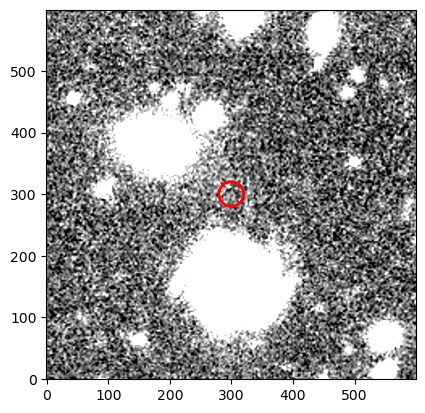

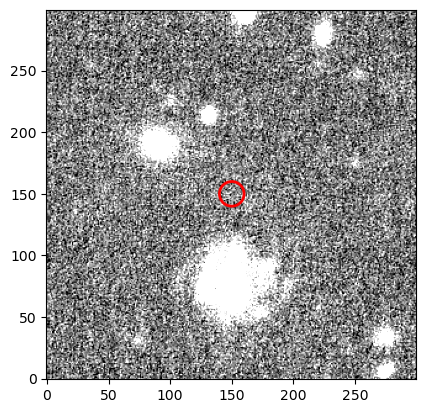

In [87]:
min_x, min_y = 700, 800
max_x, max_y = 1000, 1100
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu1 = fits.open(image_file[0])[1]
wcs1 = WCS(hdu1.header)
files = glob.glob(f'{location}/{field}/DES-G_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")]
hdu2 = fits.open(image_file[0])[0]
wcs2 = WCS(hdu2.header)
dec_min, ra_min = wcs1.wcs_pix2world(min_x, min_y, 0)
dec_max, ra_max = wcs1.wcs_pix2world(max_x, max_y, 0)
print(ra_min, dec_min, ra_max, dec_max)
x1, y1 = wcs2.wcs_world2pix(dec_min, ra_min, 0)
x2, y2 = wcs2.wcs_world2pix(dec_max, ra_max, 0)
y1, y2 = np.sort([y1, y2])
x1, x2 = np.sort([x1, x2])
print(x1, x2, y1, y2)
plt.imshow(hdu2.data[int(y1):int(y2), int(x1):int(x2)], origin='lower', cmap='gray', vmin=np.percentile(hdu2.data, 5), vmax=np.percentile(hdu2.data, 95))
circle = Circle(((x2-x1)/2, (y2-y1)/2), 20,
                edgecolor='red', facecolor='none', lw=2)

plt.gca().add_patch(circle) 
plt.show()
plt.imshow(hdu1.data[int(min_y):int(max_y), int(min_x):int(max_x)], origin='lower', cmap='gray', vmin=np.percentile(hdu1.data, 5), vmax=np.percentile(hdu1.data, 95))
circle = Circle(((max_x-min_x)/2, (max_y-min_y)/2), 10,
                edgecolor='red', facecolor='none', lw=2)

plt.gca().add_patch(circle) 
plt.show()